# Auditing Bias

## Abstract

My goal was to make a predicition of employment status based on various demographic excluding race using a subset of data from the American Community Service focused on Massachusetts residents in 2023. Based on the data of the 58,500 residents, only half were employed. Most of the time men, people without disabilities, and people who born abroad or with no citizensip had higher proportions of employment. The model I used was sklearns Decision Tree Classifier because results are easy to interpret. I tuned complexity by I using GridSearchCV which cross-validated that the best depth out of the numbers I provided was 10 which overall accuracy 0.82. The different group accuracies weren't that much different. Auditing my model showed that white people lead in PPV and FNR while Asians lead in TPR and FPR rates. In these summary I left races 5 and 6 because their data often had many missing values. Based on those values, my model failed approximate error balance and statistical parity but satisfied calibration. The plot that used the fixed PPV values and p values to graph feasible FPR and FNR combinations between Black and White residents. 

In [2]:
from folktables import ACSDataSource, ACSEmployment, BasicProblem, adult_filter
import numpy as np

STATE = "MA" 

data_source = ACSDataSource(survey_year='2023', # Get more recent data
                            horizon='1-Year', 
                            survey='person')

acs_data = data_source.get_data(states=[STATE], download=True)

acs_data.head()

,RT,SERIALNO,DIVISION,SPORDER,PUMA,REGION,STATE,ADJINC,PWGTP,AGEP,...,PWGTP71,PWGTP72,PWGTP73,PWGTP74,PWGTP75,PWGTP76,PWGTP77,PWGTP78,PWGTP79,PWGTP80
0,P,2023GQ0000077,1,1,503,1,25,1019518,11,89,...,12,13,13,13,13,13,13,12,13,13
1,P,2023GQ0000098,1,1,613,1,25,1019518,11,20,...,3,4,2,20,13,9,2,20,13,2
2,P,2023GQ0000109,1,1,613,1,25,1019518,80,68,...,28,34,78,73,34,68,82,15,17,79
3,P,2023GQ0000114,1,1,801,1,25,1019518,69,21,...,60,74,161,11,127,57,11,12,11,12
4,P,2023GQ0000135,1,1,1201,1,25,1019518,27,84,...,27,28,27,29,27,29,27,27,28,27


In [3]:
# No RELP avaiable 
possible_features=['AGEP', 'SCHL', 'MAR', 'DIS', 'ESP', 'CIT', 'MIG', 'MIL', 'ANC', 'NATIVITY', 'DEAR', 'DEYE', 'DREM', 'SEX', 'RAC1P', 'ESR']
acs_data[possible_features].head()

,AGEP,SCHL,MAR,DIS,ESP,CIT,MIG,MIL,ANC,NATIVITY,DEAR,DEYE,DREM,SEX,RAC1P,ESR
0,89,16.0,2,1,NaN,1,1.0,4.0,3,1,1,1,1.0,2,1,6.0
1,20,16.0,5,2,NaN,1,1.0,4.0,1,1,2,2,2.0,1,9,6.0
2,68,18.0,5,1,NaN,1,1.0,4.0,1,1,1,2,2.0,1,1,6.0
3,21,19.0,5,2,NaN,1,1.0,4.0,1,1,2,2,2.0,2,1,1.0
4,84,16.0,1,1,NaN,1,3.0,4.0,3,1,2,1,1.0,2,1,6.0


## Model

### Feature selection And Data Split

Adapted from Professor Phil's code. 

In [4]:
features_to_use = [f for f in possible_features if f not in ["ESR", "RAC1P"]]

In [5]:
EmploymentProblem = BasicProblem(
    features=features_to_use,
    target='ESR',
    target_transform=lambda x: x == 1,
    group='RAC1P',
    preprocess=lambda x: x,
    postprocess=lambda x: np.nan_to_num(x, -1),
)

features, label, group = EmploymentProblem.df_to_numpy(acs_data)

for obj in [features, label, group]:
  print(obj.shape)

(73126, 14)
(73126,)
(73126,)


In [6]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test, group_train, group_test = train_test_split(
    features, label, group, test_size=0.2, random_state=0)

In [7]:

import pandas as pd
df = pd.DataFrame(X_train, columns = features_to_use)
df["race"] = group_train
df["label"] = y_train

This method allows the conversion of race numbers to more helpful categorical labels. Some of them have been shortened because they were too long. 
1. SPAA - "American Indian and Alaska Native tribes specified, or American Indian or AlaskaNative, not specified and no other races". 
2. NPI - Native Hawaiian and Other Pacific Islander alone

In [8]:
def convert_race(df: pd.DataFrame):
    df = df.sort_values(by='race')
    df['race'] = df['race'].replace({1: "White", 2: "Black", 3: "N. American", 4:"N. Alaskan", 
                        5:"SPAA", 
                        6:'Asian', 7: 'NPI', 8:'Other', 9: 'Multi'})

    df['race'] = pd.Categorical(df['race'])
    return df
    

### Basic Descriptives

In [9]:
# Save to the original for calculations and copying
relabeled = df.copy() 
relabeled = convert_race(relabeled)
relabeled

,AGEP,SCHL,MAR,DIS,ESP,CIT,MIG,MIL,ANC,NATIVITY,DEAR,DEYE,DREM,SEX,race,label
0,69.0,19.0,1.0,2.0,0.0,1.0,1.0,4.0,1.0,1.0,2.0,2.0,2.0,2.0,White,False
35997,12.0,9.0,5.0,2.0,1.0,1.0,1.0,0.0,1.0,1.0,2.0,2.0,2.0,2.0,White,False
35999,70.0,24.0,1.0,2.0,0.0,1.0,1.0,4.0,2.0,1.0,2.0,2.0,2.0,1.0,White,True
36000,74.0,22.0,1.0,2.0,0.0,1.0,1.0,4.0,2.0,1.0,2.0,2.0,2.0,1.0,White,False
36001,68.0,23.0,2.0,2.0,0.0,1.0,1.0,4.0,1.0,1.0,2.0,2.0,2.0,2.0,White,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51260,6.0,3.0,5.0,2.0,2.0,1.0,1.0,0.0,1.0,1.0,2.0,2.0,2.0,2.0,Multi,False
51257,7.0,4.0,5.0,2.0,7.0,1.0,1.0,0.0,1.0,1.0,2.0,2.0,2.0,2.0,Multi,False
5335,14.0,11.0,5.0,2.0,3.0,1.0,1.0,0.0,3.0,1.0,2.0,2.0,2.0,1.0,Multi,False
34217,18.0,14.0,5.0,2.0,0.0,1.0,1.0,4.0,1.0,1.0,2.0,2.0,2.0,2.0,Multi,False


1. The number of indiviuals in this df are

In [10]:
print("The number of indiviuals in this df are", df.shape[0])

The number of indiviuals in this df are 58500


2. The proportion of employed individuals are 

In [11]:
emp = df[df['label'] == True][["label"]].size # 29703
total = df['label'].size # 58500
emp_prop = emp / total
print("The proportion of employed indiviuals are", emp_prop)

The proportion of employed indiviuals are 0.5077435897435898


3. The population of each group

In [12]:
relabeled.groupby('race')[['label']].aggregate('sum')

/var/folders/t8/bssz0nhj0h94fjkhfd648d280000gn/T/ipykernel_63227/1987727674.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  relabeled.groupby('race')[['label']].aggregate('sum')


,label
race,
Asian,2399
Black,1529
Multi,2478
N. American,52
NPI,15
Other,1284
SPAA,26
White,21920


Based on this, I might consider whether groups with less than 30 labels provide an adequate sample size.

4. The proportion of employed people in each group are:

In [13]:
relabeled.groupby('race')[['label']].aggregate('mean')

/var/folders/t8/bssz0nhj0h94fjkhfd648d280000gn/T/ipykernel_63227/802482079.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  relabeled.groupby('race')[['label']].aggregate('mean')


,label
race,
Asian,0.540315
Black,0.473668
Multi,0.456270
N. American,0.530612
NPI,0.625000
Other,0.486364
SPAA,0.520000
White,0.514687


5. Intersectional Trends

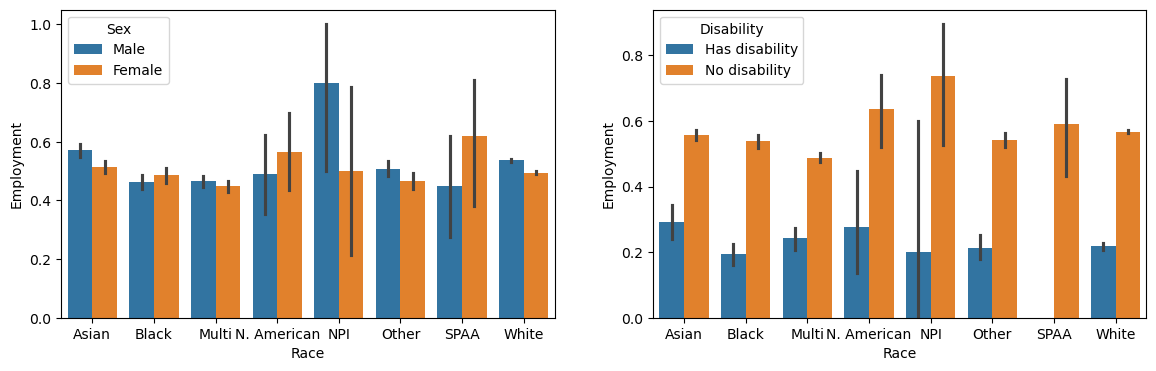

In [14]:
import seaborn as sns
from matplotlib import pyplot as plt

fig, ax = plt.subplots(1, 2, figsize = (14, 4))

colors = ["#1f77b4", "#ff7f0e"]
plt1 = sns.barplot(relabeled, x = "race", y = "label", hue="SEX", palette=colors, ax=ax[0])
plt1.set_xlabel("Race")
plt1.set_ylabel("Employment")
handles, _ = plt1.get_legend_handles_labels()
plt1.legend(handles=handles, title='Sex', labels=['Male', 'Female'])

plt2 = sns.barplot(relabeled, x = "race", y = "label", hue="DIS", palette=colors, ax=ax[1])
plt2.set_xlabel("Race")
plt2.set_ylabel("Employment")
handles, _ = plt2.get_legend_handles_labels()
plt2.legend(handles=handles, title='Disability', labels=['Has disability', 'No disability'])
plt.show()

In this we see intersectionality between employment based on the sex of the person or whether they have a disability. As we can see in both graphs generally male and able bodied people are more likely to be employed. Multiple factors can contribute to this desparity. One is that women and people with disabilities are discriminated against by employers. Another is also considering how many of them are applying for jobs. For women, even with more of them joining the workforce, they may be more likely to doing childcare at home. Because disabilites is such a broad it's hard which may be capable of working and those that aren't. This probably a big factor why relatively few are employed. Something I noticed is that for Black Americans, Native Americans and SPAA more females are employed than males. 

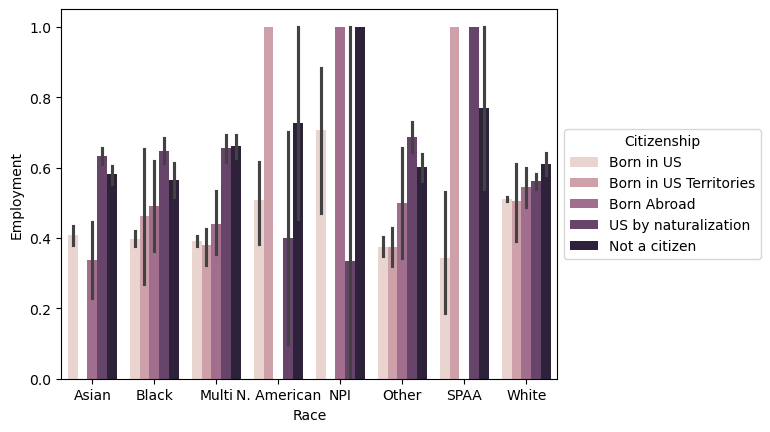

In [15]:
plt3 = sns.barplot(relabeled, x = "race", y = "label", hue="CIT")
plt3.set_xlabel("Race")
plt3.set_ylabel("Employment")
handles, _ = plt3.get_legend_handles_labels()
status = ['Born in US', 'Born in US Territories', 'Born Abroad', 'US by naturalization', 'Not a citizen']
plt3.legend(handles=handles, title='Citizenship', labels=status, loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()


In this graph, we see that for people born in the U.S or it's territories have lower percentage employment than people born abroad or by naturalization. I suspect this is might be due to the smaller populations and people to who move here are more likely to have specific work purposes.   

### Training Model

The decision tree classifier was one of the recommedations and scikit learn said it was easy to interpret. In order to find the best depth for I used GridSearchCV which cross validated the best paramaters.

In [16]:
from sklearn.tree import DecisionTreeClassifier 
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix

param_grid = {
    'max_depth': [1, 3, 5, 10]
}

model = DecisionTreeClassifier() 
grid = GridSearchCV(model, param_grid, scoring="accuracy")
grid.fit(X_train, y_train)

print("Best params", grid.best_params_)

best_dtree = grid.best_estimator_

best_dtree.predict(X_train)
best_dtree.score(X_train, y_train)

Best params {'max_depth': 10}


0.8346324786324786

The best depth was 10 and gave us a solid accuracy.

### Testing model

In [17]:
pred = best_dtree.predict(X_test)
score = best_dtree.score(X_test, y_test)

## Bias Audit

### Overall Measures

The overall accuracy:

In [18]:
(pred == y_test).mean()

np.float64(0.8217557773827431)

Here we calculate the PPV, the false negative and false positive rate

In [19]:
tn, fp, fn, tp = confusion_matrix(y_test, pred).ravel()

ppv = tp / (tp + fp)
fnr = fn / (fn + tp)
fpr = tp / (tp + tn)

print("Overall PPV:", ppv)
print("Overall false negative rate:", fnr)
print("Overall false positive rate:", fpr)


Overall PPV: 0.7937877480586712
Overall false negative rate: 0.12666124220233252
Overall false positive rate: 0.535818287711124


Based on this the model is pretty good at predicting who's not employed but seems to overestimate the amount of employed. 

### By-Group Measures

This is the accuracy by group:

In [20]:
groups = df["race"].unique() # Need race as numbers in order to compare with group_test
audit = pd.DataFrame(groups, columns=["race"])

accuracies = []
for group in groups:
   accuracy = (pred == y_test)[group_test == group].mean()
   accuracies.append(accuracy)

audit["accuracy"] = accuracies
audit = convert_race(audit)
audit


,race,accuracy
0,White,0.824244
3,Black,0.797212
7,N. American,0.843750
6,SPAA,1.000000
4,Asian,0.821859
5,NPI,0.500000
1,Other,0.804255
2,Multi,0.825095


Basides NPI and SPAA, the accuracies are rather similar to each other. 

This is the PPV, the false negative and false positive rate by group:

In [21]:
ppvs = []
tprs = []
fnrs = []
fprs = []

for group in groups:
    tp = int(0)
    fp = int(0)
    tn = int(0)
    fn = int(0)
    for n, m, grp in zip(y_test, pred, group_test):
        if(grp == group):
            if m == n:
                if n == True:
                    tp += 1
                if n == False:
                    tn += 1
            if m != n:
                if n == True:
                    fn += 1
                if n == False:
                    fp += 1
    ppv = tp / (tp + fp) if (tp + fp) > 0 else 0
    ppvs.append(ppv)
    fnr = fn / (fn + tp)  if (fn + tp) > 0 else 0
    fnrs.append(fnr)
    fpr = fp / (fp + tn) if (fp + tn) > 0 else 0 
    fprs.append(fpr)
    tpr = tp / (tp + fn) if (tp + fn) > 0 else 0
    tprs.append(tpr)
    

audit["ppv"] = ppvs
audit["tpr"] = tprs
audit["fpr"] = fprs
audit["fnr"] = fnrs
audit

,race,accuracy,ppv,tpr,fpr,fnr
0,White,0.824244,0.802562,0.868737,0.221966,0.131263
3,Black,0.797212,0.746867,0.889552,0.272973,0.110448
7,N. American,0.843750,0.769345,0.873311,0.214385,0.126689
6,SPAA,1.000000,0.737327,0.874317,0.269504,0.125683
4,Asian,0.821859,0.807588,0.901664,0.283433,0.098336
5,NPI,0.500000,0.000000,0.000000,0.000000,1.000000
1,Other,0.804255,0.000000,0.000000,0.000000,0.000000
2,Multi,0.825095,0.666667,1.000000,0.227273,0.000000


### Bias Measures

Using code adapted from [from Machine Learning Master](https://machinelearningmastery.com/calibrated-classification-model-in-scikit-learn/) and sklearn documentation, I used a sci-kit learn's calibration curve to diagnose the calibration:

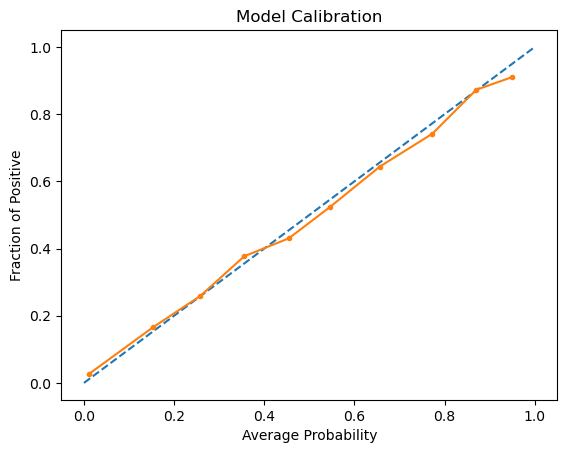

In [22]:
from sklearn.calibration import calibration_curve 


y_prob = best_dtree.predict_proba(X_test)[:, 1] # Gets the probability of positive values
prob_true, prob_pred = calibration_curve(y_test, y_prob, n_bins=10)

cal = plt
cal.plot([0, 1], [0, 1], linestyle='--') # Actual values
cal.plot(prob_pred, prob_true, marker='.') # Predicted values
cal.title("Model Calibration")
cal.xlabel("Average Probability")
cal.ylabel("Fraction of Positive")
cal.show()


The above graph shows that my model is nearly calibrated, meaning that the model usually predicts probabilites that are the same as the real probabilities. 

Approximate error balance rate: Looking at the table dataframe above we can see that the model does not meet approximate error rate balance for groups. The groups differ in true and false positive rates. The code below double checks.

In [23]:
for i, row1 in audit.iterrows():
    equal = True;
    race1 = row1['race']
    tpr1 = row1['tpr']
    fpr1 = row1['fpr']
    for j, row2 in audit.iterrows():
        race2 = row2['race']
        tpr2 = row2['tpr']
        fpr2 = row2['fpr']
        if(tpr1 != tpr2 or fpr1 != fpr2):
            equal = False
            print(f"{race1} did not have an equal TPR or FPR as {race2}")
            break
    if(equal != True):
        break
        


White did not have an equal TPR or FPR as Black


Statistical parity:

In [24]:
probs = []
for group in groups:
    prob = (pred == True)[group_test == group].mean()
    probs.append(prob)

parity= pd.DataFrame(groups, columns=["race"])
parity["prob"] = probs
parity

,race,prob
0,1,0.551474
1,8,0.565957
2,9,0.511027
3,2,0.550063
4,6,0.635112
5,7,0.000000
6,5,0.000000
7,3,0.468750


The model does not meet statistical parity which means not all groups have an equal change of achieving favorable odds. Therefore we can assume that the probability of predicting employment is not independent of race.

### Feasible FNR and FPR Rates

Add prevalance to data table

In [25]:
audit["p"] = (1 + (audit["tpr"] / audit["fpr"]) * ((1 - audit["ppv"])/(audit["ppv"]))) ** -1
audit["p"] = audit["p"].fillna(0)
audit
print(audit)

          race  accuracy       ppv       tpr       fpr       fnr         p
0        White  0.824244  0.802562  0.868737  0.221966  0.131263  0.509466
3        Black  0.797212  0.746867  0.889552  0.272973  0.110448  0.475177
7  N. American  0.843750  0.769345  0.873311  0.214385  0.126689  0.450190
6         SPAA  1.000000  0.737327  0.874317  0.269504  0.125683  0.463878
4        Asian  0.821859  0.807588  0.901664  0.283433  0.098336  0.568847
5          NPI  0.500000  0.000000  0.000000  0.000000  1.000000  0.000000
1        Other  0.804255  0.000000  0.000000  0.000000  0.000000  0.000000
2        Multi  0.825095  0.666667  1.000000  0.227273  0.000000  0.312500


Here I plot the feasibility of FPR and FNR for Black and White groups.

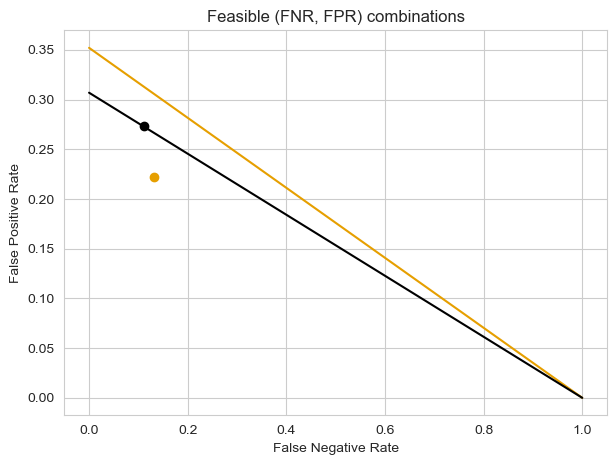

In [26]:
import seaborn as sns

# Filter to only include Black and White groups
filtered = audit[audit["race"].isin(["Black", "White"])]

orange_color = "#E69F00"
black_color = "#000000"

# A cleaner table
feasible = filtered[["race", "fpr", "fnr", "p"]].copy() 
lines = []

# Make fixed ppv based on the black ppv
fixed_ppv = filtered.loc[filtered["race"] == "Black", "ppv"].values[0]
fnr_range = np.linspace(0, 1, 100)

# Compute feasible FPR for different FNR values
for i, row in feasible.iterrows():
    race = row["race"]
    p = row["p"]  
    
    fprs = (p / (1 - p)) * ((1 - fixed_ppv) / fixed_ppv) * (1 - fnr_range)

    for fnr, fpr in zip(fnr_range, fprs):
        lines.append({"race": race, "fnr": fnr, "fpr": fpr})

lines_df = pd.DataFrame(lines)

plt.figure(figsize=(7, 5))
sns.set_style("whitegrid")

# Plot observed (fnr, fpr)
for i, row in feasible.iterrows():
    color = orange_color if row["race"] == "White" else black_color
    plt.scatter(row["fnr"], row["fpr"], color=color)

# Plot feasible (fnr, fpr) line
for race, color in zip(["White", "Black"], [orange_color, black_color]):
    line = lines_df[lines_df["race"] == race]
    plt.plot(line["fnr"], line["fpr"], color=color)

plt.xlabel("False Negative Rate")
plt.ylabel("False Positive Rate")
plt.title("Feasible (FNR, FPR) combinations")
plt.show()

Based on this plot, to get equal false positive rates we would need to increase $\mathrm{FNR}_w$ by about 0.9.

## Concluding Discussion

1. If we assume that these institutions don't already have employment data, then it could be used by finacial and government institutions. For example, a bank may use employment status prediction to determine whether to give a loan to someone. The government could use its prediction to determine where they need to improve in providing employment opportunities. Landlords could use this information to decide if they want to accept a tenant or how much they would to charge them. 

2. Since my model proved to not be fair, then commercial or government industries would be misguided in their decisions. This algorithm may be used to unreasonably target certain populations with advertisements. Some people may be missclassified which would either disallow them from certian opportunities or stop them from getting the help they need. 

3. My model failed tests of statistical parity and error rate balance which means that it does display problematic biases.

4. I think transparency might be an issue, if the algorithm is not shared to the public as people would unknownigly be judged by a algorithm.  I'm unsure if this bias but smaller populations have very weird data points that probably don't accurate reflect what's going on. I feel like there could be some social bias or judgement as result of this algorithm, especially for people who aren't employed or predicted to not be employed. 